In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

# Introduction  

There is an seemingly never ending supply of financial data, and the Quandl package offers relatively easy access to not only the raw prices but also more advanced indicators. I am only going to focus on the adjusted closing prices of one company: Tesla.

In [2]:
# quandl for financial data
import quandl
quandl.ApiConfig.api_key = 'TuxigqPxhP2_J8YE7ThL'
# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')
tesla.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0


Tesla is quite an interesting company, for a variety of reasons: it is the first successful automobile start-up in the United States in over 110 years, it surpassed General Motors for market cap at time in 2017 and, oh, Elon Musk. General Motors, on the other hand, was founded in 1908, currently produces and markets over 30 different models, filed for Chapter 11 bankruptcy on June 1, 2009 and received over 10 billion US dollars in bailout money. Tesla currently manufactures 5 different automobiles.  

**Plot the time series, along with any logical or necessary differences to get a stationary dataset**

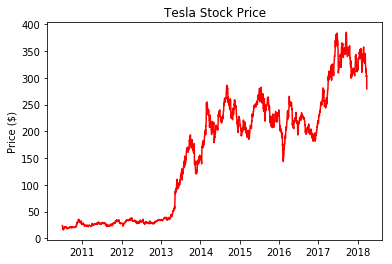

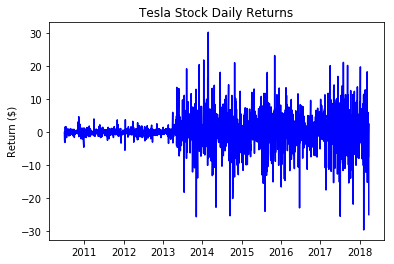

In [6]:
tesla['Daily Returns'] = tesla['Adj. Close'] - tesla['Adj. Close'].shift()


# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();



plt.plot(tesla.index, tesla['Daily Returns'], 'b')
plt.title('Tesla Stock Daily Returns')
plt.ylabel('Return ($)');
plt.show();

**Generate and interpret a PACF for the time series (and/or its differences)**

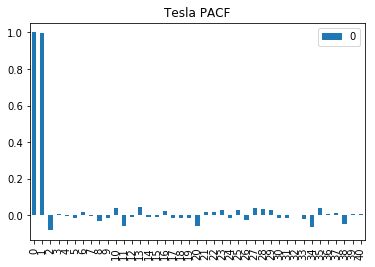

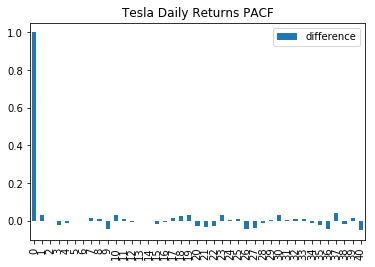

In [7]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(tesla['Adj. Close']))
x_acf.plot(kind='bar')
plt.title("Tesla PACF")
plt.show()

x_acf = pd.DataFrame(pacf(tesla['Daily Returns'][1:]))
x_acf.plot(kind='bar')
plt.title("Tesla Daily Returns PACF")
plt.legend(['difference'])
plt.show()

So the daily returns both appear to be stationary.

**Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data**

In [10]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


# Your code here.
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [13]:
# evaluate parameters
p_values = range(0,5)
d_values = [1]
q_values = range(0, 5)
evaluate_models(tesla['Adj. Close'].values, p_values, d_values, q_values)

ARIMA(0, 1, 0) MSE=40.464
ARIMA(0, 1, 1) MSE=40.444
ARIMA(0, 1, 2) MSE=40.514
ARIMA(0, 1, 3) MSE=40.564
ARIMA(0, 1, 4) MSE=40.683
ARIMA(1, 1, 0) MSE=40.445
ARIMA(2, 1, 0) MSE=40.510
ARIMA(2, 1, 1) MSE=40.623
ARIMA(3, 1, 0) MSE=40.555
ARIMA(3, 1, 1) MSE=40.631
ARIMA(4, 1, 0) MSE=40.679
ARIMA(4, 1, 1) MSE=40.728
Best ARIMA(0, 1, 1) MSE=40.444


**Finally choose one specification and make the case for that as a logical model for your dataset.**  

Given these hyperparameters, and only using AIC and log-likelihood values I would go with (3,1,1) for an ARIMA model to forecast GM prices, and (4,1,1) for Tesla prices. However, I do not expect these models to accurately forecast GM or Tesla prices, so I will use Prophet.

In [16]:
import fbprophet


# Need the date field for Prophet
tesla.reset_index(inplace=True)
# Prophet requires columns ds (Date) and y (value)
tesla2 = tesla.rename(columns={'Date': 'ds', 'Adj. Close': 'y'})
# Make the prophet model and fit on the data
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
tesla_prophet.fit(tesla2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


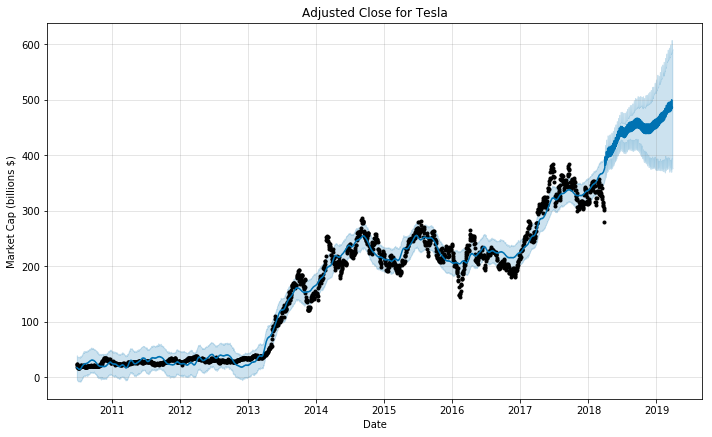

In [17]:
# Make a future dataframe for 2 years
tesla_forecast = tesla_prophet.make_future_dataframe(periods=365, freq='D')
# Make predictions
tesla_forecast = tesla_prophet.predict(tesla_forecast)

tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Adjusted Close for Tesla');

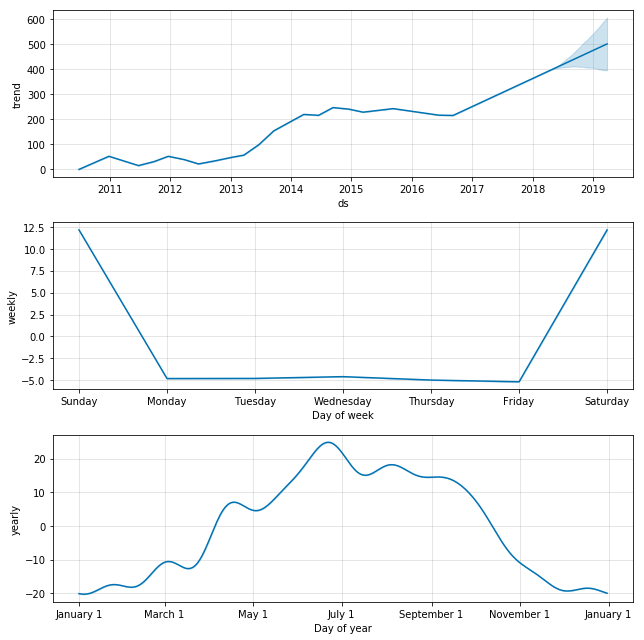

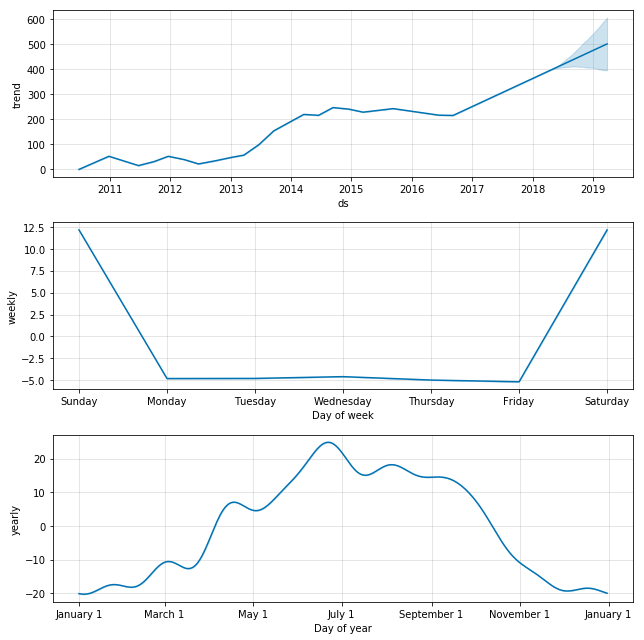

In [18]:
# Plot the trends and patterns
tesla_prophet.plot_components(tesla_forecast)

# SARIMA  

The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time series data that may contain trend and seasonal components. Financial data almost certainly contains trends and or seasonal components, so this type of model seems appropriate here.  

This will test about 1290 different hyperparameter configurations, so I moved this computation to Kaggle (not very confident in my laptop hardware), you can find the notebook [here](https://www.kaggle.com/mjmurphy28/time-series-models-arima-sarimax-and-prophet), this is the best configuration:

# Conclusion  

I fit 12 different ARIMA models to the Tesla data, with the best scoring model having a RMSE of 40.444, or about 12.3% of the average adjusted close price for Tesla for the last 30 days.

The ARIMA models do not take trends or seasonality into effect, so the next model I chose to work with was naturally the set of SARIMA(X) models. Our best scoring SARIMAX model had a RMSE of 6.251, or about 1.9% of the average adjusted close price for Tesla for the last 30 days.  

Prophet offers a lot of features right out of the box; here I particularly utilize Prophet for visualizing seasonality/trends as well as forecasting.